## Experiments with PageRank

In [1]:
import matplotlib.pyplot as plt
import networkit as nk
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import dask
from dask import delayed
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
from scipy import sparse
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from tqdm import tqdm

import utils

In [2]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=10)
top_categories = [
#     'Folders',                     # N=645
#     'Self-Adhesive Labels',        # N=324
#     'Multimedia Carts & Stands',   # N=317
#     'Calculators',                 # N=305
#     'Writing Notebooks'            # N=300
#     'Ring Binders',                # N=298
#     'Printer Cabinets & Stands',   # N=252
    'Whiteboards',                 # N=232
#     'Fax Machines',                # N=210
    'File Storage Boxes'           # N=192
#     'Binding Covers',              # N=190
#     'Self-Adhesive Note Paper',    # N=172
#     'Staplers',                    # N=162
#     'Desk Trays/Organizers',       # N=159
#     'Board Accessories',           # N=154
#     'Seals',                       # N=145
#     'Computer Desks',              # N=144
#     'Hole Punches',                # N=136
#     'Hanging Folders',             # N=132
#     'Interactive Whiteboards',     # N=131
#     'Laminator Pouches',           # N=128
#     'Stationery Tapes',            # N=124
#     'Bulletin Boards',             # N=123
#     'Tab Indexes',                 # N=114
#     'Folder Binding Accessories',  # N=109
#     'Non-Adhesive Labels',         # N=103
]
df_data = df_data[df_data.category_name.isin(top_categories)]

# Sort by category for later visualisation
df_data.sort_values('category_name', inplace=True)

product_features = utils.get_product_feature_columns_for_training(df_data)
df_play_data = df_data[['category_name'] + product_features].copy()

In [3]:
df_data.category_name.value_counts()

Whiteboards           232
File Storage Boxes    192
Name: category_name, dtype: int64

In [4]:
X = utils.preprocess_dataframe(df_play_data)
X.shape

(424, 171)

In [5]:
# Reduce to number of dimensions so the remaining dimensions
# explain at least 90 percent of the variance.
svd = PCA(n_components=0.9, random_state=42)
X_pca = svd.fit_transform(X)
X_pca.shape

(424, 19)

In [6]:
similarity_matrix = cosine_similarity(X_pca)

# Ensure similarity matrix entries are normalised in the range [0,1]
similarity_matrix = (similarity_matrix - np.min(similarity_matrix)) / np.ptp(similarity_matrix)

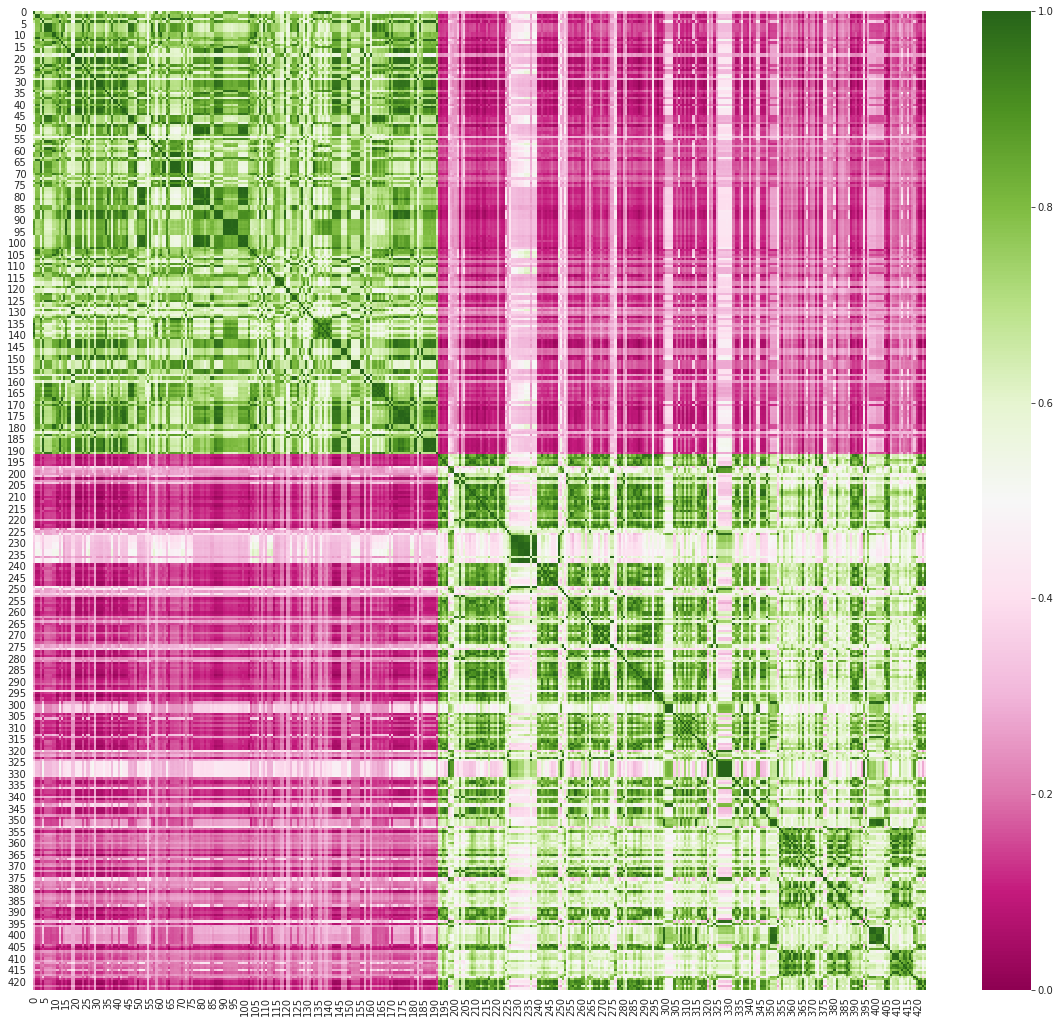

In [7]:
utils.plot_similarity_heatmap(X_pca, metric='cosine', normalise=True)

## Community Detection

In [8]:
g = nk.Graph(weighted=True, directed=False)

n = similarity_matrix.shape[0]
g.addNodes(n)
for i in range(n):
    for j in range(i, n):
        if i != j:
            g.addEdge(i, j, similarity_matrix[i, j])

In [9]:
communities = nk.community.detectCommunities(g)

PLM(balanced,pc,turbo) detected communities in 0.0049533843994140625 [s]
solution properties:
-------------------  ----------
# communities          2
min community size   192
max community size   232
avg. community size  212
modularity             0.268467
-------------------  ----------


In [10]:
nk.community.Modularity().getQuality(communities, g)

0.26846691702402303

## Personalised PageRank

In [12]:
cluster = LocalCluster()
client = Client(cluster)

In [13]:
cluster

In [14]:
client

Client Scheduler: tcp://127.0.0.1:35687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 37.42 GiB


In [15]:
def compute_page_rank_with_category_bias(dataframe: pd.DataFrame, product_index: int, product_category: str, graph):
    df = dataframe.copy()  # Avoids modifying the original data.
    
    # Save the original product category for later.
    original_product_category = df.loc[product_index, 'category_name']
    
    # Change the category of the given product.
    df.loc[product_index, 'category_name'] = product_category
    
    # When the walker teleports then bias it towards the given product category
    # but do not allow the walker to teleport to the current product.
    product_indices = df[df.category_name == product_category].index.tolist()
    product_indices = [i for i in product_indices if i != product_index] # Exclude current page
    n_rows = len(product_indices)
    personalisation = {i: (1.0/n_rows) for i in product_indices}
    
    # Run Personalised PageRank with damping factor (alpha) set to 0.85.
    # Damping factor is the probability that at any step the walker
    # will continue to an adjacent vertex. With 1-alpha the walker will
    # teleport to a vertex given in the personalisation at random.
    ppr = nx.pagerank(
        G=graph,
        alpha=0.85,
        personalization=personalisation,
    )
    
    return {
        'product_index': product_index,
        'original_product_category': original_product_category,
        'new_product_category': product_category,
        'rank': ppr[product_index]
    }

### Test Individual PageRank Computations

In [16]:
weighted_graph = nx.from_numpy_matrix(similarity_matrix)

df_data_fixed_index = df_play_data.reset_index().copy()

In [17]:
compute_page_rank_with_category_bias(df_data_fixed_index, 200, 'Whiteboards', weighted_graph)

{'product_index': 200,
 'original_product_category': 'Whiteboards',
 'new_product_category': 'Whiteboards',
 'rank': 0.0021650421941628857}

In [18]:
compute_page_rank_with_category_bias(df_data_fixed_index, 200, 'File Storage Boxes', weighted_graph)

{'product_index': 200,
 'original_product_category': 'Whiteboards',
 'new_product_category': 'File Storage Boxes',
 'rank': 0.0017333026429225888}

In [19]:
compute_page_rank_with_category_bias(df_data_fixed_index, 200, 'File StorageBoxes', weighted_graph)

{'product_index': 200,
 'original_product_category': 'Whiteboards',
 'new_product_category': 'File StorageBoxes',
 'rank': 4.821640515545411e-06}

### Run algorithm

In [17]:
df_data_fixed_index = df_play_data.reset_index()

n_rows = df_data_fixed_index.shape[0]
categories = df_data_fixed_index.category_name.unique()

data_future = client.scatter(df_data_fixed_index)
graph_future = client.scatter(weighted_graph)

results = []
for i in range(n_rows):
    for category in categories:
        #result = delayed(compute_page_rank_with_category_bias)(df_data_fixed_index, i, category, weighted_graph)
        result = delayed(compute_page_rank_with_category_bias)(data_future, i, category, graph_future)
        results.append(result)

results = dask.compute(*results)

In [54]:
df_results = pd.DataFrame(list(results))
df_results['is_true_cat'] = df_results['original_product_category'] == df_results['new_product_category']

In [55]:
df_results

,product_index,original_product_category,new_product_category,rank,is_true_cat
0,0,File Storage Boxes,File Storage Boxes,0.002257,True
1,0,File Storage Boxes,Whiteboards,0.001755,False
2,1,File Storage Boxes,File Storage Boxes,0.002446,True
3,1,File Storage Boxes,Whiteboards,0.001616,False
4,2,File Storage Boxes,File Storage Boxes,0.002446,True
...,...,...,...,...,...
843,421,Whiteboards,Whiteboards,0.002405,True
844,422,Whiteboards,File Storage Boxes,0.001622,False
845,422,Whiteboards,Whiteboards,0.002239,True
846,423,Whiteboards,File Storage Boxes,0.001553,False


In [61]:
df_results.to_excel('../data/page-rank-results-file-storage-boxes-vs-whiteboards.xlsx')

In [57]:
idx = df_results.groupby(['product_index'])['rank'].transform(max) == df_results['rank']

In [60]:
df_results[idx]

,product_index,original_product_category,new_product_category,rank,is_true_cat
0,0,File Storage Boxes,File Storage Boxes,0.002257,True
2,1,File Storage Boxes,File Storage Boxes,0.002446,True
4,2,File Storage Boxes,File Storage Boxes,0.002446,True
6,3,File Storage Boxes,File Storage Boxes,0.002336,True
8,4,File Storage Boxes,File Storage Boxes,0.002460,True
...,...,...,...,...,...
839,419,Whiteboards,Whiteboards,0.002342,True
841,420,Whiteboards,Whiteboards,0.002377,True
843,421,Whiteboards,Whiteboards,0.002405,True
845,422,Whiteboards,Whiteboards,0.002239,True


In [62]:
df_results[idx].to_excel('../data/page-rank-results-file-storage-boxes-vs-whiteboards-highest-rank.xlsx')